In [1]:
# !pip install -q --upgrade pandas matplotlib seaborn scikit-learn sklearn imbalanced-learn
# import sklearn, imblearn
# print(sklearn.__version__)

In [2]:
import warnings
from time import perf_counter as timer
from pprint import pprint
from IPython.display import Markdown

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc_file_defaults

from sklearn.experimental import enable_halving_search_cv
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, HalvingRandomSearchCV
from sklearn.metrics import get_scorer, make_scorer, confusion_matrix, roc_curve

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from joblib import Memory
from tempfile import mkdtemp
from shutil import rmtree

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

In [3]:
random_state = 123

# Appointments' No-show analysis

https://www.kaggle.com/joniarroba/noshowappointments

## Table of contents
- [Dataset](#Dataset)
- [EDA](#EDA)
    - [Target variable](#Target-variable)
    - [Age](#Age)
    - [Age vs. medical conditions](#Age-vs.-medical-conditions)
    - ['No-show' in relation to other variables](#'No-show'-in-relation-to-other-variables)
    - [Correlation](#Correlation)
- [Feature engineering](#Feature-engineering)
    - [Previous no-show](#Previous-no-show)
    - [Time difference](#Time-difference)
    - [Weekend](#Weekend)
    - [Neighbourhood](#Neighbourhood)
    - [Correlation](#Correlation2)
- [Data split](#Data-split)
- [Pipeline](#Pipeline)
- [Metrics](#Metrics)
- [Dummy model](#Dummy-model)
- [Parameters grid](#Parameters-grid)
- [Model reports](#Model-reports)

In [4]:
def reset_plt_style():
    rc_file_defaults()
    plt.rcParams.update({
        'grid.alpha': 0,
        'axes.grid': False,
        'figure.figsize': (11, 5),
        'legend.fontsize': 'x-large',
        'axes.labelsize': 'x-large',
        'axes.titlesize':'xx-large',
        'xtick.labelsize':'x-large',
        'ytick.labelsize':'x-large',
    })
    
reset_plt_style()

<br>

## Dataset
***
[back](#Table-of-contents)

In [5]:
filename = 'KaggleV2-May-2016.csv'
# filename = 'https://github.com/dm6801/noshow_dataset/raw/master/KaggleV2-May-2016.csv'

In [6]:
!wc -l "$filename"
!head -n2 "$filename"

  110528 KaggleV2-May-2016.csv
PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


#### Variables' description:

    PatientId - identification of a patient;
    AppointmentID - identification of each appointment;
    Gender - male or female;
    ScheduledDay - day when a patient registered for an appointment;
    AppointmentDay - day of actuall appointment;
    Age - patient age;
    Neighbourhood - where the appointment takes place (hospital location);
    Scholarship - 1 for True, 0 for False. For more details read the article (the link is here: https://bit.ly/3AYv4GF);
    Hipertension - 1 for True, 0 for False;
    Diabetes - 1 for True, 0 for False;
    Alcoholism - 1 for True, 0 for False;
    Handcap - number of disabilities a patient has;
    SMS_received - 1 if one or more messages were sent to the patient;
    No-show - 'No' if the patient showed up to their appointment, 'Yes' if they did not show up.

In [7]:
data = pd.read_csv(filename, parse_dates=['ScheduledDay', 'AppointmentDay'])

In [8]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientId       110527 non-null  float64            
 1   AppointmentID   110527 non-null  int64              
 2   Gender          110527 non-null  object             
 3   ScheduledDay    110527 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110527 non-null  datetime64[ns, UTC]
 5   Age             110527 non-null  int64              
 6   Neighbourhood   110527 non-null  object             
 7   Scholarship     110527 non-null  int64              
 8   Hipertension    110527 non-null  int64              
 9   Diabetes        110527 non-null  int64              
 10  Alcoholism      110527 non-null  int64              
 11  Handcap         110527 non-null  int64              
 12  SMS_received    110527 non-null  int64              
 13  No-show       

In [9]:
data.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No


<br>

## EDA
***
[back](#Table-of-contents)

- [Target variable](#Target-variable)
- [Age](#Age)
- [Age vs. medical conditions](#Age-vs.-medical-conditions)
- ['No-show' in relation to other variables](#'No-show'-in-relation-to-other-variables)
- [Correlation](#Correlation)

In [10]:
def reposition_target_column(target='No-show'):
    data.insert(0, target, data.pop(target))                      # start
    # data.insert(len(data.columns)-1, target, data.pop(target))  # end

In [11]:
def label_bars(ax, y, func=None):
    
    def label(height):
        if height > 0:
            return func(height) if callable(func) else f'{height:,}'
        else:
            return ''
    
    for c in ax.containers:
        labels = [label(b.get_height()) for b in c]
        ax.bar_label(c, labels=labels, label_type='edge')

In [12]:
def plot_target_var_dist(figsize=None):
    if figsize:
        plt.figure(figsize=figsize)
        
    ax = sns.histplot(data['No-show'])
    ax.set_ymargin(.14)
    ax.set_title("'No-show' distribution")
    label_bars(ax, data['No-show'], func=lambda x:f"{x/data['No-show'].count():.1%}")
    ax.set_xticks(data['No-show'].unique())

In [13]:
data.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [14]:
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [15]:
numerical_columns = ['Age', 'Handcap']

In [16]:
binary_columns = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received']

In [17]:
data.describe(include='datetime64[ns, UTC]', datetime_is_numeric=True)

,ScheduledDay,AppointmentDay
count,110527,110527
mean,2016-05-09 07:49:15.846273024+00:00,2016-05-19 00:57:50.008233472+00:00
min,2015-11-10 07:13:56+00:00,2016-04-29 00:00:00+00:00
25%,2016-04-29 10:27:01+00:00,2016-05-09 00:00:00+00:00
50%,2016-05-10 12:13:17+00:00,2016-05-18 00:00:00+00:00
75%,2016-05-20 11:18:37+00:00,2016-05-31 00:00:00+00:00
max,2016-06-08 20:07:23+00:00,2016-06-08 00:00:00+00:00


In [18]:
date_columns = ['ScheduledDay', 'AppointmentDay']

In [19]:
data.describe(include='O')

,Gender,Neighbourhood,No-show
count,110527,110527,110527
unique,2,81,2
top,F,JARDIM CAMBURI,No
freq,71840,7717,88208


In [20]:
binary_columns.append('Gender')

In [21]:
categorical_columns = ['Neighbourhood']

In [22]:
data['PatientId'].nunique()

62299

In [23]:
data.isna().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

There are no missing values.

In [24]:
data['AppointmentID'].duplicated().sum()

0

There are no duplicated entries.

In [25]:
_print_cols = lambda *cols:[print(f"{c.split('_')[0]+':':<15}", globals()[c]) for c in cols]
display(Markdown('### Feature types: <br>'))
_print_cols('numerical_columns', 'binary_columns', 'categorical_columns', 'date_columns');

### Feature types: <br>

numerical:      ['Age', 'Handcap']
binary:         ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received', 'Gender']
categorical:    ['Neighbourhood']
date:           ['ScheduledDay', 'AppointmentDay']


### Target variable

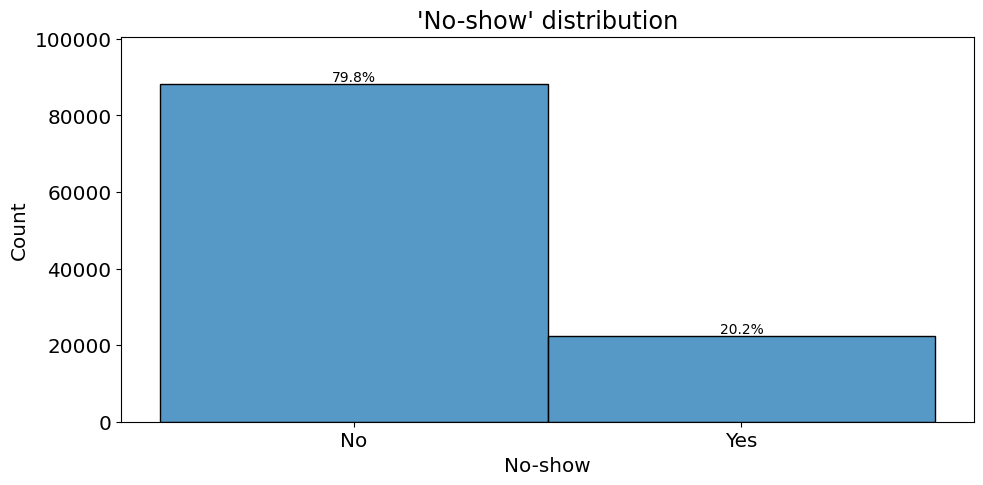

In [26]:
plot_target_var_dist()

We can see a significant class imbalance of 4:1.

### Age

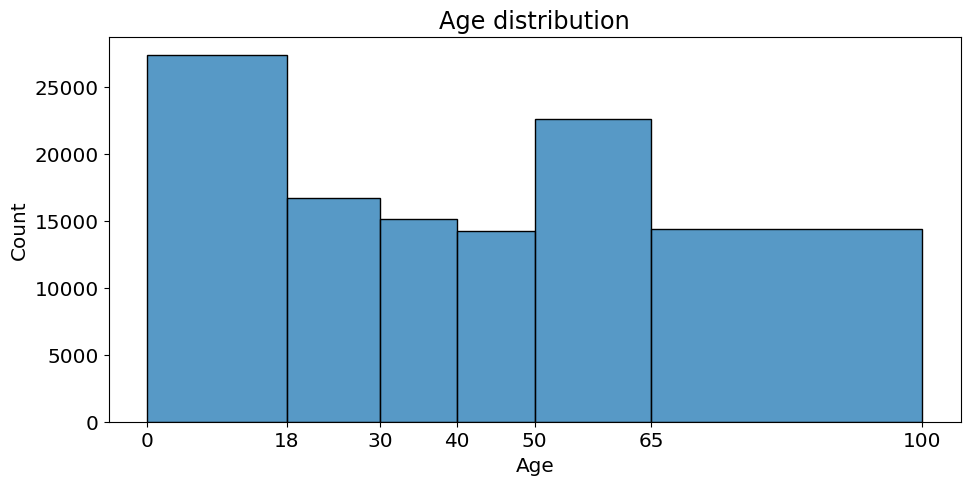

In [27]:
age_bins = [0, 18, 30, 40, 50 ,65, 100]
sns.histplot(data['Age'], bins=age_bins).set_xticks(age_bins)
plt.title('Age distribution')
plt.show()

There are more people represented in the 0-18 and 50-65 groups than other age groups.

Checking records with age < 0:

In [28]:
len(data[data['Age'] < 0])

1

In [29]:
data[data['Age'] < 0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,-1,ROMÃO,0,0,0,0,0,0,No


Let's check whether this patient has more appointments:

In [30]:
data[data['PatientId'].isin(data[data['Age'] < 0]['PatientId'])]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,-1,ROMÃO,0,0,0,0,0,0,No


The above entry seems erroneous,  
a single record of a person with age -1, no medical conditions and False for the target variable.  
Removing from the dataset.

In [31]:
data.drop(data[(data['Age'] < 0)].index, inplace=True)
data.reset_index(drop=True, inplace=True)

In [32]:
len(data[data['Age'] < 0])

0

Checking records with age = 0:

In [33]:
data.loc[data['Age'] == 0, ['Age', 'Hipertension', 'Alcoholism']].groupby('Age').sum()

,Hipertension,Alcoholism
Age,,
0,0,0


There are no patients with age = 0 and medical conditions which fit older ages, looks like legitimate data (probably babies).

### Age vs. medical conditions

,Hipertension,Alcoholism
Age,,
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
5,0,1
6,0,0
7,4,2
8,1,1


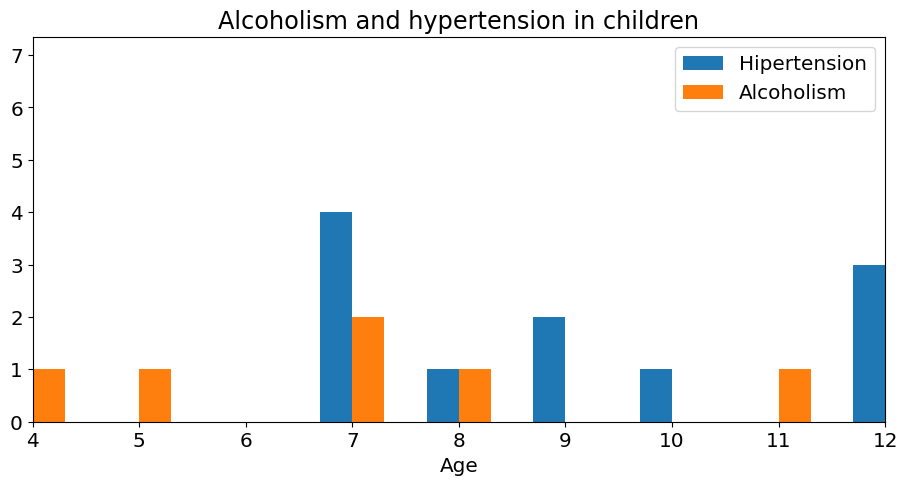

In [34]:
kids_medical_conditions = data[['Age', 'Hipertension', 'Alcoholism']].query('Age <= 12')
kids_medical_conditions.groupby('Age').sum().pipe(lambda x:(x.plot.bar(width=.6), display(x)))
plt.xticks(rotation=0)
plt.title('Alcoholism and hypertension in children')
plt.xlim((4,12))
plt.show()

In [35]:
data[['Age', 'Hipertension', 'Alcoholism', 'Scholarship', 'No-show']].query('Age <= 12 and Alcoholism == 1').sort_values(by='Age')

,Age,Hipertension,Alcoholism,Scholarship,No-show
86546,4,0,1,0,No
32817,5,0,1,0,Yes
17463,7,0,1,0,No
56008,7,0,1,0,No
80263,8,0,1,0,No
6402,11,0,1,1,No
53536,12,0,1,0,Yes
53549,12,0,1,0,Yes
53587,12,0,1,0,Yes
53733,12,0,1,0,Yes


### 'No-show' in relation to other variables

In [36]:
def compare_categorical(x, y, normalize=False):
    label = 'count' if not normalize else 'percent'
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    # fig.tight_layout()
    
    for _x, ax in zip(x, axes):
        df = (data.groupby(_x)[y]
              .value_counts(normalize=normalize)
             .rename(label)
             .reset_index())

        # print(df, '\n')
        ax.set_ymargin(.1)
        sns.barplot(data=df, x=_x, y=label, hue=y, ax=ax)
        label_bars(ax, df[label], (lambda x:f'{x:.1%}') if normalize else (lambda x:f'{x:,.0f}'))

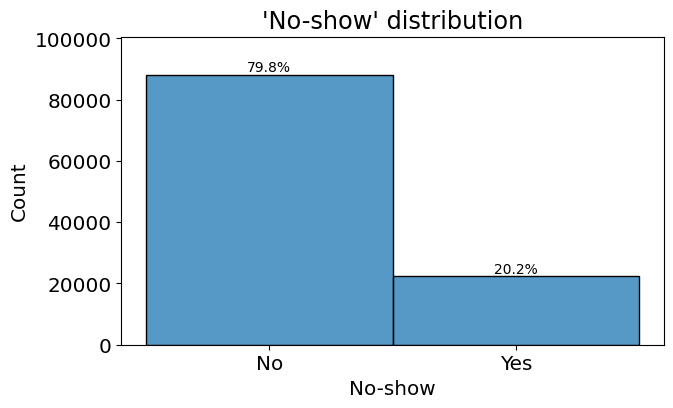

In [37]:
plot_target_var_dist(figsize=(7, 4))

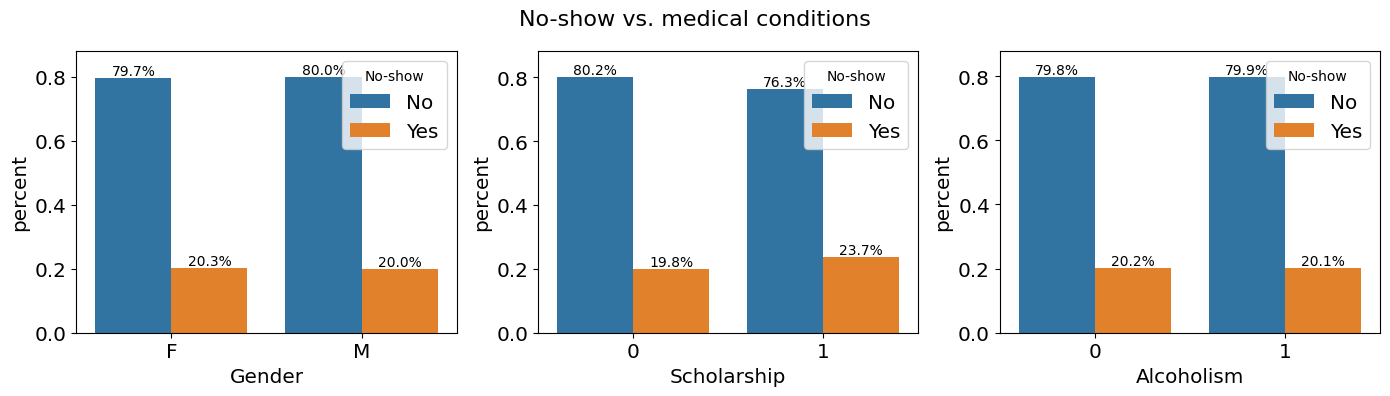

In [38]:
compare_categorical(['Gender', 'Scholarship', 'Alcoholism'], 'No-show', normalize=True)
plt.suptitle('No-show vs. medical conditions', fontsize=16)
plt.tight_layout()
plt.show()

The medical conditions variables seem to follow the imbalance of the target class.

### Correlation

In [39]:
def plot_correlation(corr):
    plt.figure(figsize=(25,12))
    sns.set(font_scale=1.4)
    sns.heatmap(corr,
                annot=True,
                mask=np.triu(np.ones_like(corr, dtype=bool)),
                cmap=sns.diverging_palette(230, 20, as_cmap=True), center=0)
    plt.title('Correlations')
    plt.show()
    reset_plt_style()

In [40]:
data['No-show'] = data['No-show'].map({'No': 0, 'Yes': 1})

In [41]:
reposition_target_column('No-show')

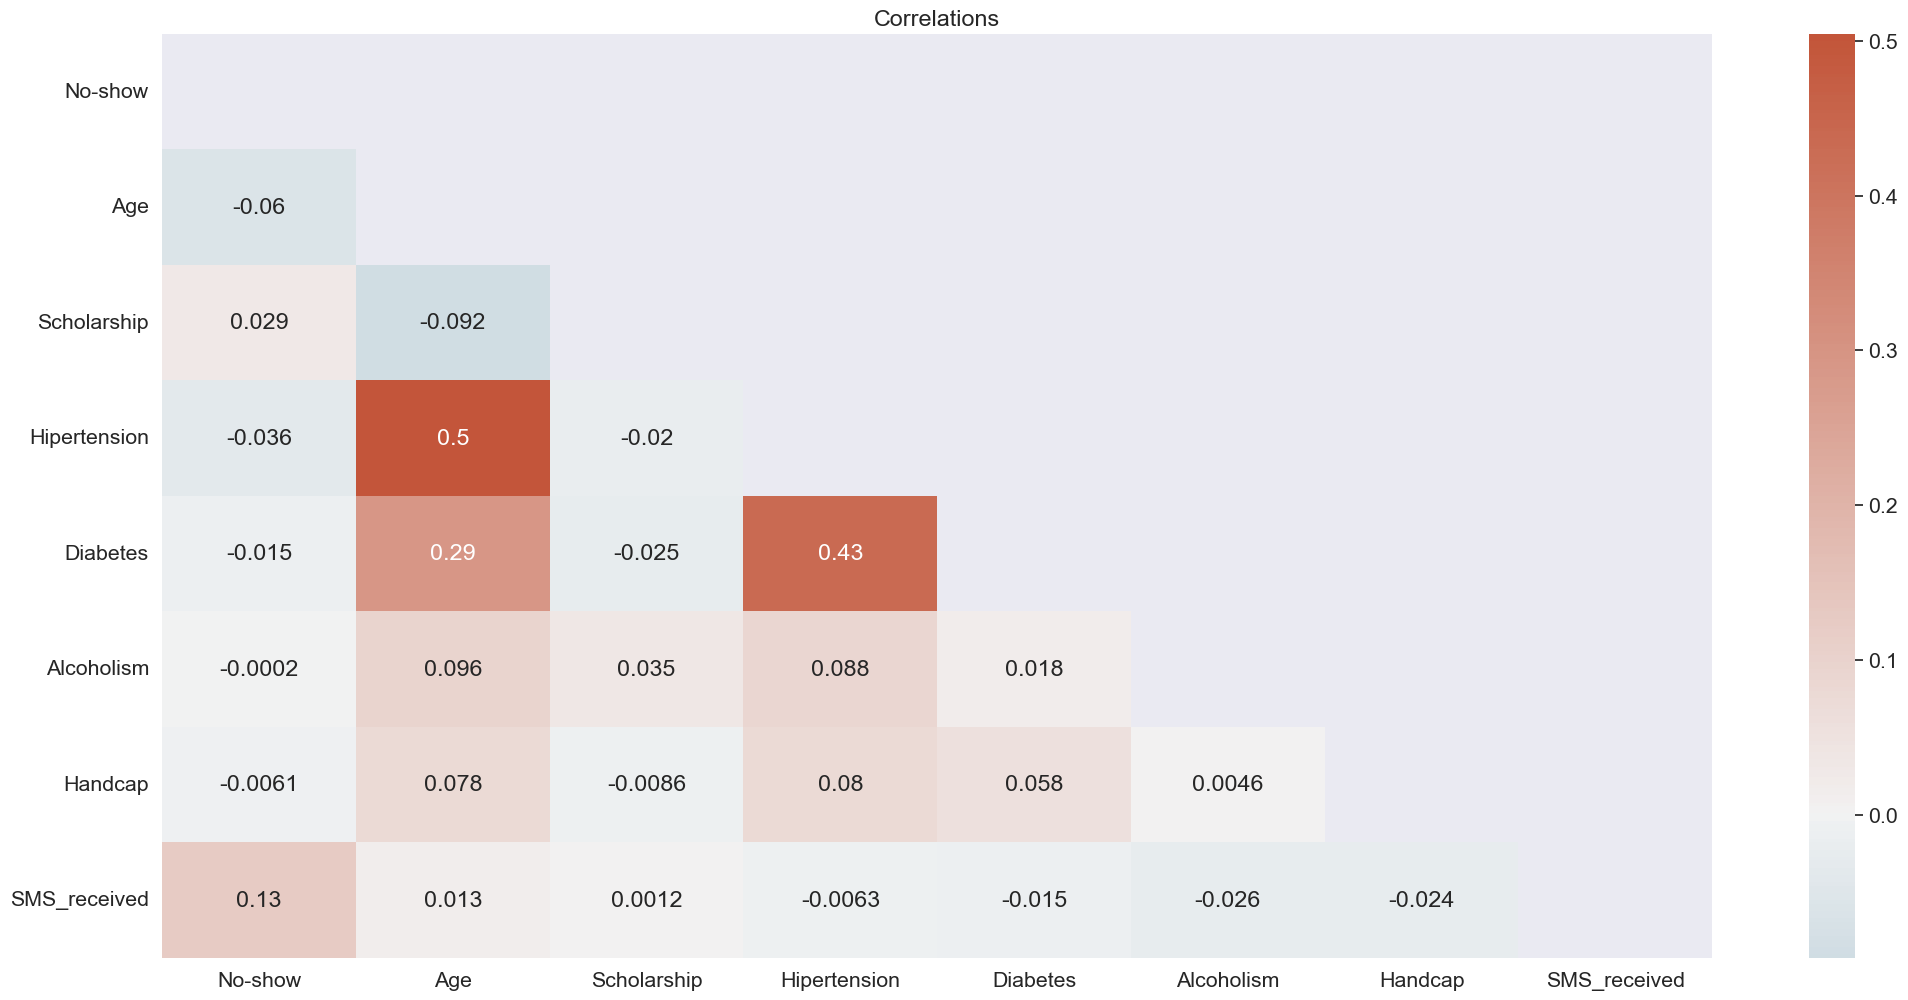

In [42]:
plot_correlation(data.drop(['PatientId', 'AppointmentID'], axis=1).corr())

<br>

## Feature engineering
***
[back](#Table-of-contents)

- [Previous no-show](#Previous-no-show)
- [Time difference](#Time-difference)
- [Weekend](#Weekend)
- [Neighbourhood](#Neighbourhood)
- [Correlation](#Correlation2)

In [43]:
def binary_encode(series, prefix=''):
    assert series.dtype == np.object_, f'{series.name} is not of object dtype'
    
    _range = np.arange(series.nunique())+1
    ordinal_category = data['Neighbourhood'].map(
        pd.Series(data=_range, index=series.unique()))
    # print(_range, '\n', ordinal_category)
    
    zfill = len(bin(ordinal_category.max())[2:])
    # print('zfill:', zfill)
    
    binary = ordinal_category.apply(
        lambda x:bin(x)[2:].zfill(zfill)
    ).str.split('', expand=True).iloc[:,1:-1].astype('int8')
    
    if prefix:
        binary.columns = [f'{prefix}{c}' for c in binary.columns]
    
    return binary

# binary_encode(data['Neighbourhood'], prefix='n_')

### Previous no-show

In [44]:
previous_no_show = (data[['PatientId', 'No-show']]
                    .pivot_table(
                        index='PatientId',
                        values='No-show',
                        aggfunc='sum')
                    .squeeze()
                    .rename('previous_no_show').to_frame())

previous_no_show
0                   44635
1                   14437
2                    2418
3                     516
4                     162
5                      58
6                      33
7                      13
8                       9
11                      4
10                      4
9                       3
12                      1
13                      1
14                      1
15                      1
16                      1
18                      1
dtype: int64


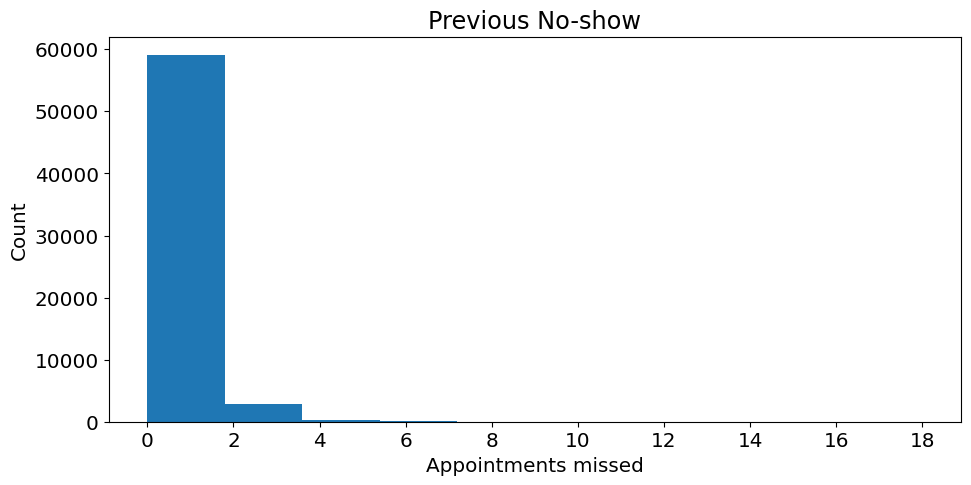

In [45]:
previous_no_show.hist()
plt.title('Previous No-show')
plt.xlabel('Appointments missed')
plt.ylabel('Count')
(lambda vc:(print(vc), plt.xticks(range(0, vc.index.max()[0]+1, 2))))(previous_no_show.value_counts());

In [46]:
data = data.merge(previous_no_show.reset_index())
data.columns

Index(['No-show', 'PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received',
       'previous_no_show'],
      dtype='object')

### Time difference

0    0
1    0
2    0
3    0
4    0
dtype: int64

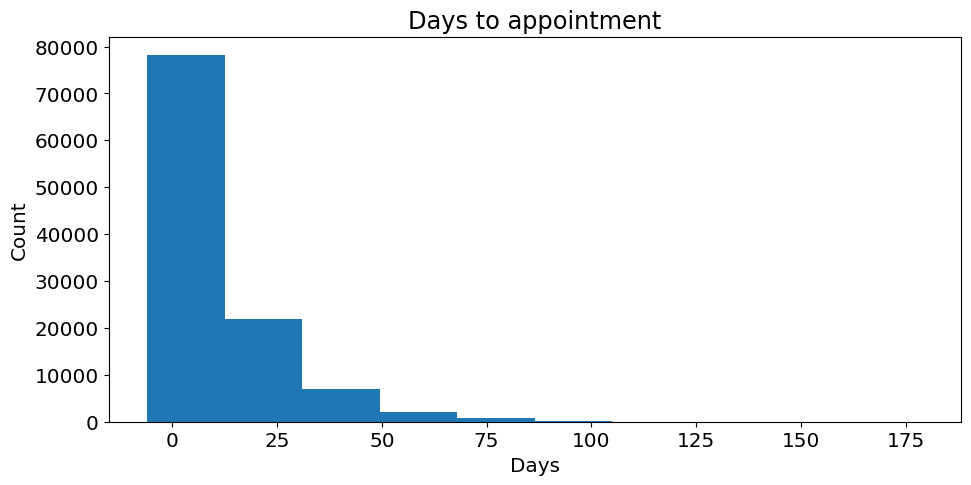

In [47]:
days_diff = pd.Series(data['AppointmentDay'].values.astype('datetime64[D]')
                      - data['ScheduledDay'].values.astype('datetime64[D]')).dt.days
days_diff.hist()
plt.title('Days to appointment')
plt.xlabel('Days')
plt.ylabel('Count')
days_diff.head()

In [48]:
days_diff.describe()

count    110526.000000
mean         10.183794
std          15.255034
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
dtype: float64

There are records where the appointment day is _before_ the scheduling day, which doesn't make sense.

In [49]:
data.iloc[days_diff[days_diff < 0].index]

,No-show,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,previous_no_show
9184,1,7.839273e+12,5679978,M,2016-05-10 10:51:53+00:00,2016-05-09 00:00:00+00:00,38,RESISTÊNCIA,0,0,0,0,1,0,1
53724,1,7.896294e+12,5715660,F,2016-05-18 14:50:41+00:00,2016-05-17 00:00:00+00:00,19,SANTO ANTÔNIO,0,0,0,0,1,0,2
73706,1,2.425226e+13,5664962,F,2016-05-05 13:43:58+00:00,2016-05-04 00:00:00+00:00,22,CONSOLAÇÃO,0,0,0,0,0,0,2
88862,1,9.982316e+14,5686628,F,2016-05-11 13:49:20+00:00,2016-05-05 00:00:00+00:00,81,SANTO ANTÔNIO,0,0,0,0,0,0,2
89440,1,3.787482e+12,5655637,M,2016-05-04 06:50:57+00:00,2016-05-03 00:00:00+00:00,7,TABUAZEIRO,0,0,0,0,0,0,1


In [50]:
data['days_diff'] = days_diff

In [51]:
data.drop(data[data['days_diff'] < 0].index, inplace=True)
data.reset_index(drop=True, inplace=True)

In [52]:
len(data[data['days_diff'] < 0])

0

### Day of week

In [53]:
data['weekday'] = pd.to_datetime(data['AppointmentDay']).dt.weekday

In [54]:
data['weekday'] = pd.to_datetime(data['AppointmentDay']).dt.weekday.astype('int8')

2    25866
1    25638
0    22713
4    19019
3    17246
5       39
Name: weekday, dtype: int64

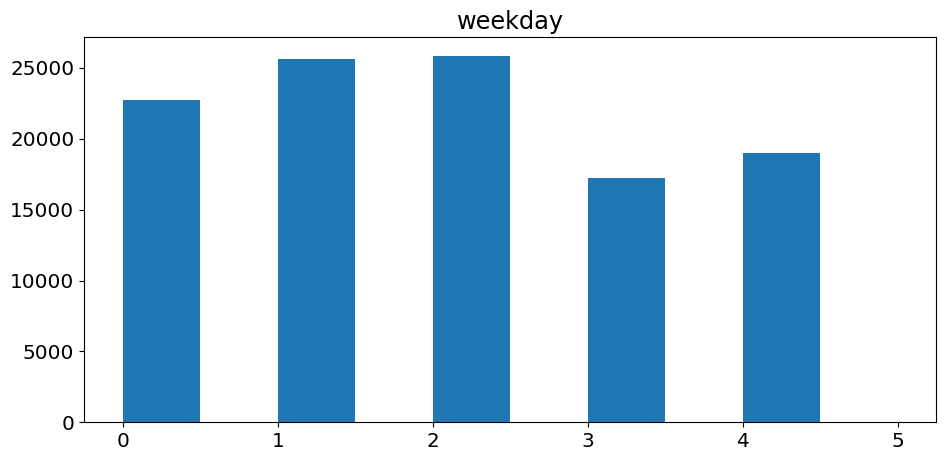

In [55]:
data['weekday'].hist()
plt.title('weekday')
plt.xticks(data['weekday'].unique())
data['weekday'].value_counts()

### Weekend

In [56]:
data['weekend'] = pd.to_datetime(data['AppointmentDay']).dt.weekday.isin([5,6]).astype('int')

0    110482
1        39
Name: weekend, dtype: int64

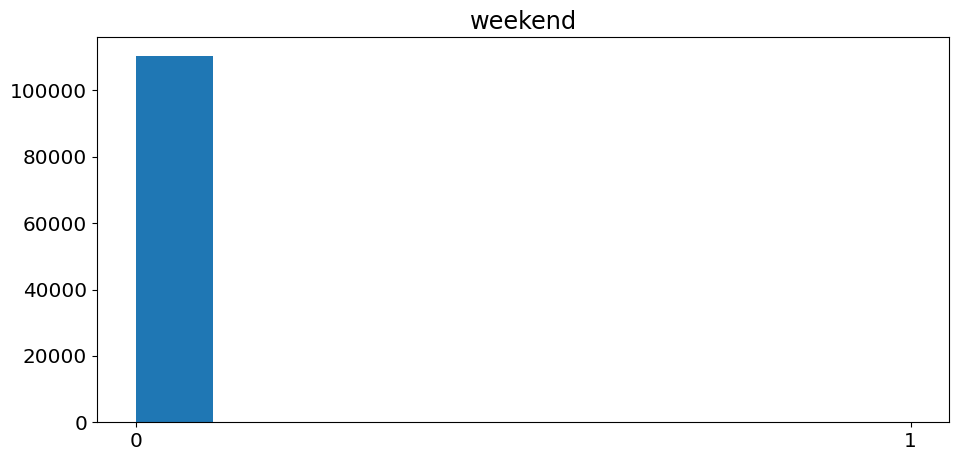

In [57]:
data['weekend'].hist()
plt.title('weekend')
plt.xticks(data['weekend'].unique())
data['weekend'].value_counts()

### Neighbourhood

In [58]:
data['Neighbourhood'].nunique()

81

In [59]:
binary = binary_encode(data['Neighbourhood'], prefix='n_')
print(binary.shape)
binary.head()

(110521, 7)


,n_1,n_2,n_3,n_4,n_5,n_6,n_7
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0


In [60]:
data = data.join(binary)
data.columns

Index(['No-show', 'PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'previous_no_show',
       'days_diff', 'weekday', 'weekend', 'n_1', 'n_2', 'n_3', 'n_4', 'n_5',
       'n_6', 'n_7'],
      dtype='object')

In [61]:
data.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], axis=1, inplace=True)

In [62]:
reposition_target_column('No-show')

### Correlation<a id='Correlation2'></a> 

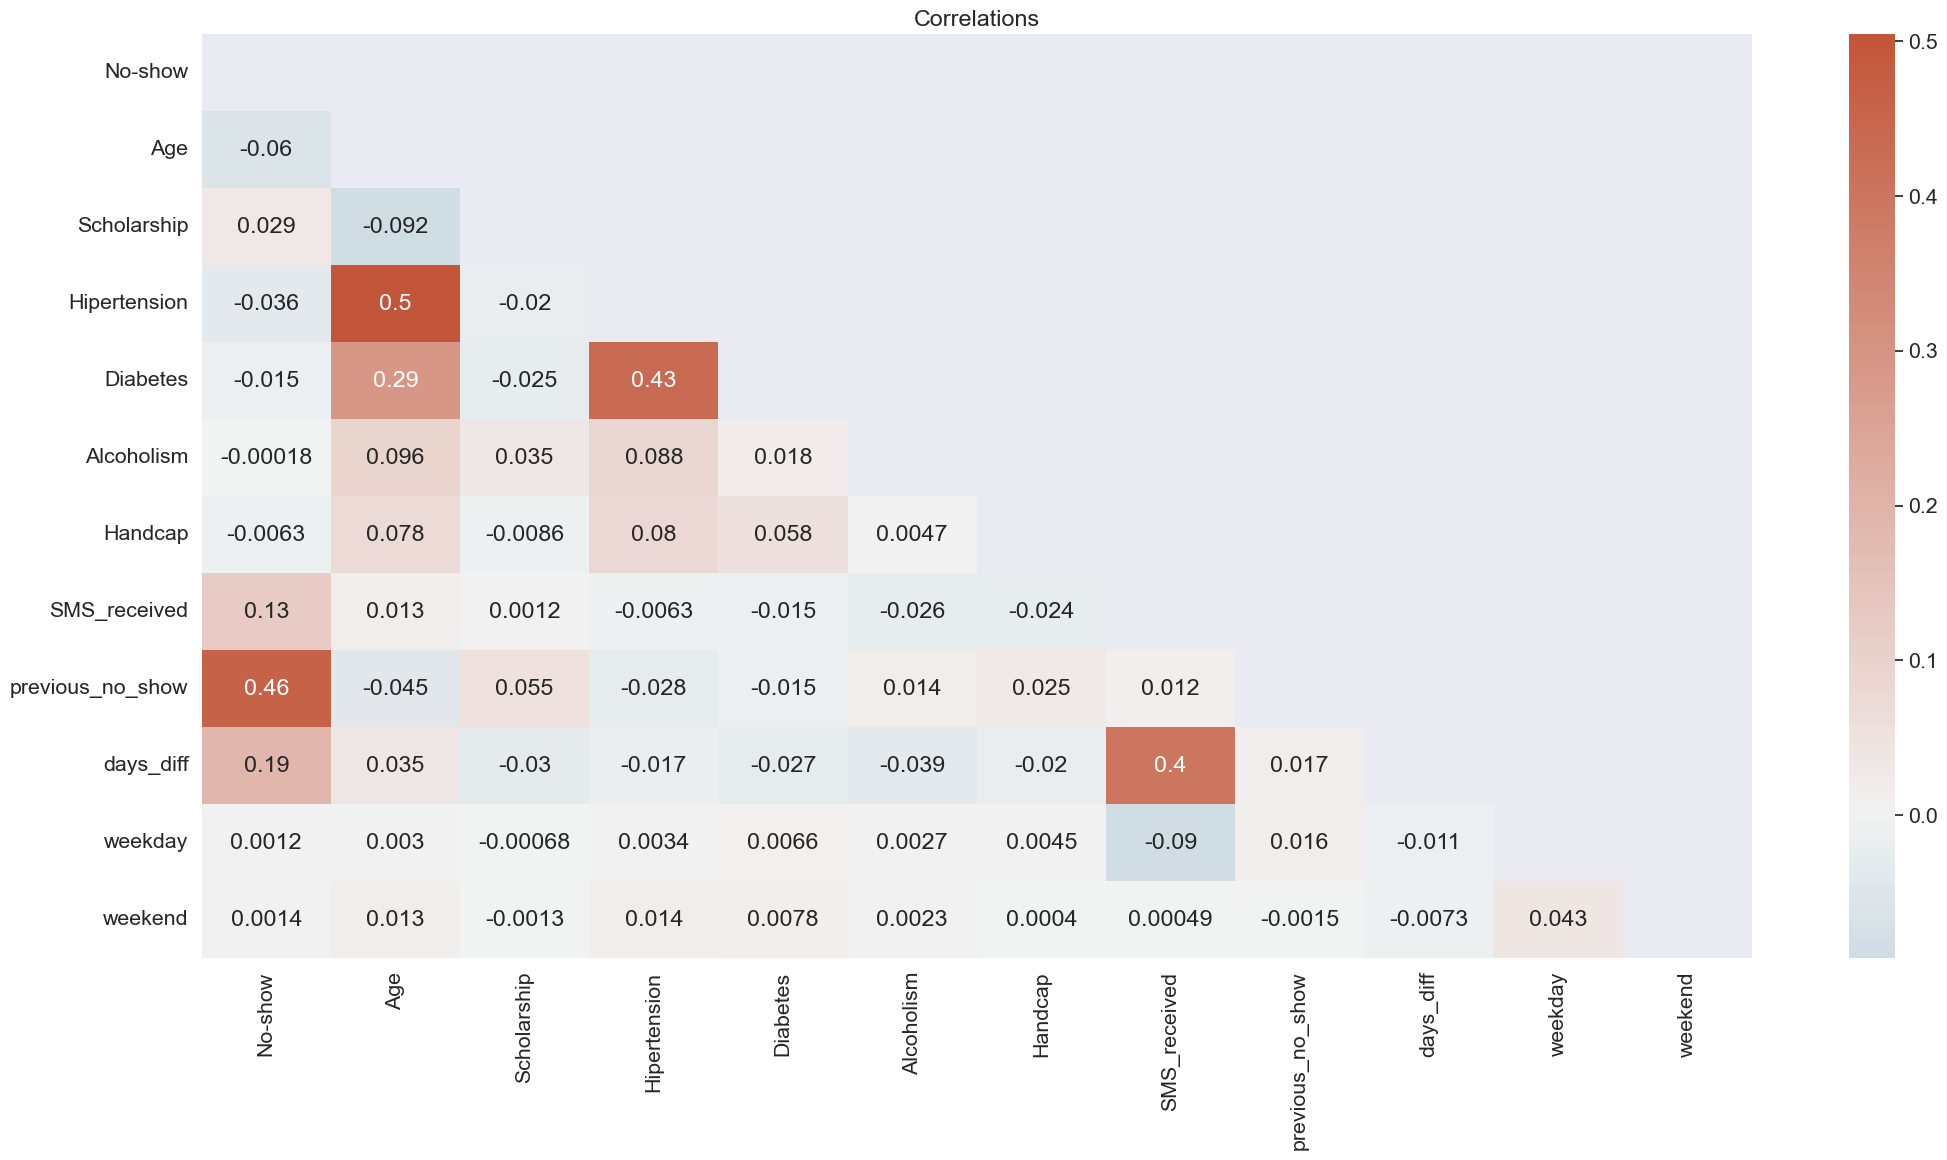

In [63]:
plot_correlation(data.drop(binary.columns, axis=1).corr())

<br>

## Data split
***
[back](#Table-of-contents)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('No-show', axis=1), data['No-show'],
                                                    test_size=.25,
                                                    stratify=data['No-show'],
                                                    random_state=random_state)

<br>

## Pipeline
***
[back](#Table-of-contents)

In [65]:
class DebugTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    

    def fit(self, X, y=None):
        # print('__debug fit', X.shape, y.shape if isinstance(y, pd.Series) else None)
            # .pipe(lambda x:(print(x), display(x.plot.bar()), plt.show()))
            
        self.class_ratio = (pd.Series(y)
                            .value_counts(normalize=True).to_frame()
                            .apply(lambda x:(x[0]/x[1]).round())[0])
        print(self.__class__.__name__, 'fit, class ratio: ', self.class_ratio)
        return self 
    

    def transform(self, X, y=None):
        
        print(self.__class__.__name__, 'transform, ', X.shape, y.shape if isinstance(y, pd.Series) else None)
        return X

In [66]:
def create_pipeline(model, cache=None, verbose=0, **kwargs):
    steps = [('transform', kwargs.get('transform', col_tf))]
    
    if kwargs.get('over_under'):
        steps.append(
            ('over_under', SMOTETomek(
                tomek=TomekLinks(sampling_strategy='majority'), random_state=random_state, n_jobs=-1)))
    
    if kwargs.get('oversample'):
        steps.append(
            ('over_sample', RandomOverSampler(random_state=random_state)))
        
    if kwargs.get('undersample'):
        steps.append(
            ('under_sample', RandomUnderSampler(random_state=random_state)))
    
    if verbose:
        steps.append(('debug', DebugTransformer()))
    
    steps.append(('clf', model))
    
    return Pipeline(steps, memory=cache, verbose=verbose)
    
#     return Pipeline(steps=[
#         ('process', col_tf),
#         # ('over_under', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=random_state, n_jobs=-1)),
#         ('over_sample', RandomOverSampler(random_state=random_state)),
#         # ('under_sample', RandomUnderSampler(random_state=random_state)),
#         ('debug', DebugTransformer()),
#         ('clf', model),
#     ], memory=cache, verbose=verbose)

In [67]:
def feature_names(obj, cols=None):
    if isinstance(obj, ColumnTransformer):
        tuples = obj.transformers
    elif isinstance(obj, Pipeline):
        tuples = [e.transformers_
                  for e in np.concatenate(obj.steps).tolist()
                  if hasattr(e, 'transformers_')][0]

    names = np.concatenate([t[2] for t in tuples if t[1] != 'drop'])
    
    return [cols[int(name)] if name.isnumeric() and isinstance(cols, pd.Index) else name 
            for name in names]

# feature_names(col_tf, data.columns)

In [68]:
def transform_columns(ops, verbose=0, **kwargs):
    tuples = []
    for op_name, cols in ops.items():
        # print(op_name, cols)
        
        if not cols:
            continue
        
        if op_name == 'scale':
            op = StandardScaler()
        elif op_name == 'label':
            op = OrdinalEncoder()
        else:
            op = 'passthrough'
            
        tuples.append((op_name, op, cols))
        
    return ColumnTransformer(tuples, verbose=verbose, n_jobs=-1, **kwargs)

In [69]:
column_operations = {
    'scale': [
        'Age', 
        'Handcap', 
        'previous_no_show', 
        'days_diff',
        'weekday',
    ],
    'label': [
        'Gender'
    ],
    'passthrough': [
        'Scholarship', 
        'Hipertension', 
        'Diabetes', 
        'Alcoholism', 
        'SMS_received', 
        'weekend',
        *binary.columns,
    ]
}

In [70]:
col_tf = transform_columns(column_operations)

<br>

## Metrics
***
[back](#Table-of-contents)

In [71]:
metrics = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

In [72]:
def compute_scores(y_true, y_pred=None, y_score=None,
                   as_series=False,
                   metrics=metrics):
    
    def _score(func, *args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            return np.NaN

        
    def score(name):
        func = get_scorer(name)._score_func
        
        if name == 'roc_auc':
            return name, _score(func, y_true, y_score)
        elif name == 'precision' or name == 'recall' or name == 'f1':
            return name, _score(func, y_true, y_pred, zero_division=0)
        else:
            return name, _score(func, y_true, y_pred)
    
    
    results = dict(map(score, metrics))
    results.update(zip(['true_negative', 'false_positive', 'false_negative', 'true_positive'],
                       confusion_matrix(y_true, y_pred, normalize='true').flatten()))
    
    if as_series:
        return pd.Series(results)
    else:
        return results

# compute_scores([0, 1, 1, 1], [1, 0, 1, 1], [0.7, 0.7, 0.7, 0.7], as_series=True)

In [73]:
def plot_confusion_matrix(cm, ticks=None, rotate_ylabels=False, fmt='l\n\nv\nn', **kwargs):
    """Plots a confusion matrix"""
    
    labels = [['TN', 'FP'], 
              ['FN', 'TP']]
    
    # norm_values = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    norm_values = cm.astype('float') / cm.sum(axis=1).reshape(-1, 1)
    
    def label(i, j):
        nonlocal fmt
        
        if cm.shape != (2, 2):
            fmt = fmt.replace('l', '')
            
        if '\n' not in fmt:
            fmt = '\n\n'.join(fmt)
            
        return fmt.replace('v', f'{cm[i][j]:,}') \
                  .replace('n', f'{norm_values[i][j]:.2f}') \
                  .replace('l', str(labels[i][j]))
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, **kwargs)
    plt.colorbar(im, ax=ax)

    middle_value = np.max(cm) // 2
    dark_color = im.cmap(255)
    for i in range(2):
        for j in range(2):
            value = cm[i, j]
            color = 'w' if value > middle_value else dark_color
            plt.text(j, i, label(i, j), ha="center", va="center", color=color)

    if ticks == None:
        ticks = y_test.unique()
        
    ax.set_title('Confusion Matrix')
    
    ax.set_xlabel('Predicted label')
    ax.set_xticks(range(len(ticks)))
    ax.set_xticklabels(ticks)
    
    ax.set_ylabel('Actual label')
    ax.set_yticks(range(len(ticks)))
    
    if rotate_ylabels:
        ax.set_yticklabels(ticks, rotation=90, va='center')
    else:
        ax.set_yticklabels(ticks)
    
    plt.show()

In [74]:
def plot_roc_curve(y_true, y_proba):
    """Plots ROC (Receiver Operating Characteristic) curve"""
    
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr)

    # ROC curve for random model (looks like a straight line)
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlim([0, 1])
    plt.xlabel("False Positive Rate")
    
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    
    plt.title("ROC curve")
    plt.show()
    
    return fpr, tpr, thresholds

<br>

## Dummy model
***
[back](#Table-of-contents)

In [75]:
dummy_strategies = ["stratified", "most_frequent", "prior", "uniform", "constant"]

In [76]:
def dummy_scores(pick=None, verbose=0):
    models = {}
    scores = []
    
    for strategy in dummy_strategies:
        kwargs = dict(
            random_state=random_state,
            strategy=strategy,
        )

        if strategy == 'constant':
            kwargs['constant'] = 1

        dummy = make_pipeline(col_tf, DummyClassifier(**kwargs), verbose=verbose)
        dummy.fit(X_train, y_train)
        y_pred = dummy.predict(X_test)
        y_proba = dummy.predict_proba(X_test)[:, 1]
        
        models[strategy] = (dummy, y_pred, y_proba)
        scores.append(compute_scores(y_test, y_pred, y_proba, as_series=True).rename(strategy))

    df = pd.DataFrame(scores)
    best_strategy = pick if pick else df.mean(axis=1).idxmax() 
    best_model, y_pred, y_proba = models[best_strategy]
    
    display(Markdown(f'### {best_strategy} dummy model'))
    display(df.style.set_properties(**{
        'background-color': 'rgba(128, 128, 128, .3)',
        'background-blend-mode': 'multiply',
    }, subset=pd.IndexSlice[best_strategy, :]))
    plot_roc_curve(y_test, y_proba)
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), cmap='Greens')
        
# dummy_scores()

### uniform dummy model

,accuracy,recall,precision,f1,roc_auc,true_negative,false_positive,false_negative,true_positive
stratified,0.681300,0.203979,0.206796,0.205378,0.503019,0.802059,0.197941,0.796021,0.203979
most_frequent,0.798089,0.000000,0.000000,0.000000,0.500000,1.000000,0.000000,1.000000,0.000000
prior,0.798089,0.000000,0.000000,0.000000,0.500000,1.000000,0.000000,1.000000,0.000000
uniform,0.497955,0.488797,0.198371,0.282210,0.500000,0.500272,0.499728,0.511203,0.488797
constant,0.201911,1.000000,0.201911,0.335983,0.500000,0.000000,1.000000,0.000000,1.000000


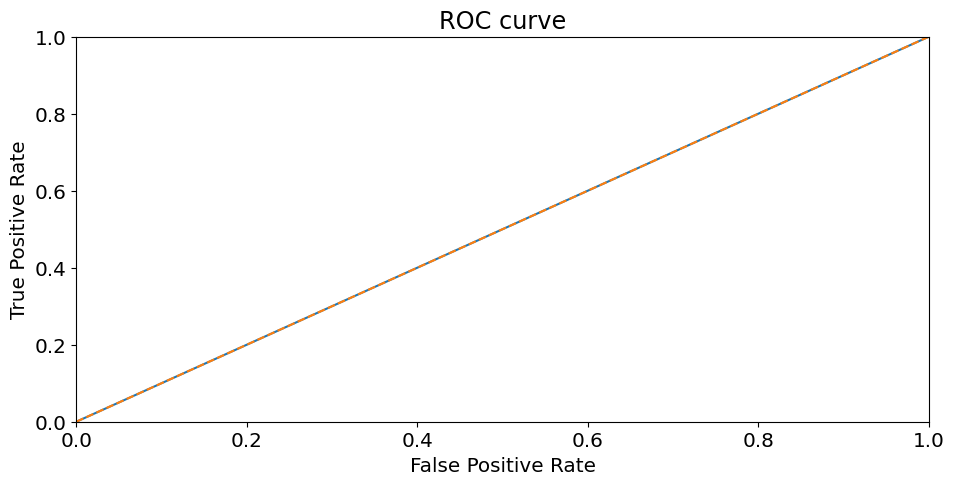

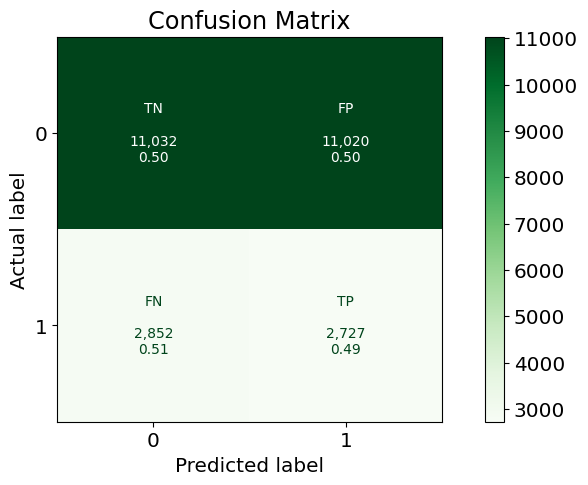

In [77]:
dummy_scores(dummy_strategies[3])

TN means the dataset has 0 for no-show (patient will come), and we have predicted the same.  
FP means the dataset has 0 for no-show, but we have predict no-show to be 1 (patient won't come) - when the patient actually did come.  
We would like to minimize FP so there will be no unexpected patients showing up to a clinic.  
To do so, we should aim for high Precision.

- https://www.notion.so/Chapter-Summary-Classification-Metrics-40a723a4a1ed44739d95583034323238

<br>

## Parameters grid
***
[back](#Table-of-contents)

In [78]:
def halving_search(scoring, params_grid, verbose=0, **kwargs):
    scores = []
    best_params = {}
    cache = mkdtemp()
    memory = Memory(cache, verbose=verbose)
    
    def model_factory(cls, **kwargs):
        try:
            return cls(random_state=random_state, **kwargs)
        except:
            try:
                return cls(**kwargs)
            except:
                try:
                    return cls(random_state=random_state)
                except:
                    return cls()
            
    
    def _print(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)
            
            
    def _display(*arg, **kwargs):
        if verbose:
            display(*args, **kwargs)
    
    
    for i, (model_class, params) in enumerate(params_grid.items()):
        model_time = timer()
        
        model = model_factory(model_class) #, class_weight='balanced')
        model_name = model_class.__name__
        _print(model_name, '...', sep='')
        
        pipeline = create_pipeline(model, memory, verbose, **kwargs)
        params = {'clf__'+k:v for k,v in params.items()}
        
        hrscv = HalvingRandomSearchCV(pipeline,
                                      param_distributions=params,
                                      scoring=scoring,
                                      cv=StratifiedKFold(shuffle=True, random_state=random_state),
                                      n_jobs=-1,
                                      random_state=random_state)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            fit_time = timer()
            hrscv.fit(X_train, y_train)
            fit_time = timer() - fit_time

            predict_time = timer()
            y_pred = hrscv.predict(X_test)
            predict_time = timer() - predict_time
            
            try:
                y_proba = hrscv.predict_proba(X_test)[:, 1]
            except:
                y_proba = np.NaN
        
        if verbose and i==0:
            print(feature_names(hrscv.best_estimator_))
            processed_df = pd.DataFrame(
                hrscv.best_estimator_.named_steps['transform'].transform(X_test),
                columns=feature_names(hrscv.best_estimator_))
            display(processed_df.head(), processed_df.shape)

        _print(hrscv.best_estimator_, f'train time: {fit_time:.2f}s', sep='\n')
        
        best_params[model_name] = {k[len('clf__'):]:v 
                                  for k,v in hrscv.best_params_.items()
                                  if k.startswith('clf__')}
        scores.append(compute_scores(y_test, y_pred, y_proba, as_series=True)
                      .rename(model_name))
        
        model_time = timer() - model_time
        _print(f'{model_name} finished in {model_time:,.2f}s')
        _print()
        
    rmtree(cache)
    
    pprint(best_params, width=1)
    print()
    
    return (pd.DataFrame(scores).style.set_properties(
        **{
            'background-color': 'rgba(128, 128, 128, .1)',
            'background-blend-mode': 'multiply',
        }, subset=[scoring]),
            best_params)

In [79]:
# %%time
# halving_search('f1', params_grid={LogisticRegression: dict()},
#                verbose=1, oversample=True, undersample=True)[0]

In [80]:
def tune_hyper(metrics, grid, verbose=0, **kwargs):
    results = {}
    
    for metric in metrics:
        time = timer()
        
        print(f'\n\nOptimizing for {metric}..\n')
        df, params = halving_search(metric, grid, verbose=verbose, **kwargs)
        time = timer() - time
        
        display(df)
        print(f'{metric} took {(time):,.2f}s')
        
        results[metric] = params
        
    return results

In [81]:
params_grid = {
    LogisticRegression: dict(
        solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        tol=[1e-4, 1e-3],
        C=[1.0, 1e-1],
    ),
    RandomForestClassifier: dict(
            n_estimators=[100, 120, 130],
            max_depth=[2, 3, 7, 10],
            criterion=['gini', 'entropy'],
            # min_samples_split=[2, 3, 4, 5],
            # min_samples_leaf=[1, 2, 3, 4],
    ),
    GradientBoostingClassifier: dict(
        n_estimators=[100, 120, 130],
        max_depth=[2, 3, 7, 10],
        # loss=['deviance', 'exponential'],
        # learning_rate=[1e-1, 1e-2, 1e-3],
    ),
    AdaBoostClassifier: dict(
        n_estimators=[40, 50, 60],
        learning_rate=[1, 1e-1, 1e-2],
    ),
    GaussianNB: dict(
        # var_smoothing=[1e-09, 1e-08, 1e-07],
    ),
    # HistGradientBoostingClassifier: dict(
    #     # max_depth=[2, 3, 7, 10],
    # ),
    # SVC: dict(),
    # LinearSVC: dict(),
    # KNeighborsClassifier: dict(
    #     # weights=['uniform', 'distance'],
    #     n_neighbors=[np.floor(len(X_train)**.5).astype('int')],
    # ),
}

In [82]:
%%time
results = tune_hyper(['precision'], params_grid, oversample=True, undersample=True)



Optimizing for precision..

{'AdaBoostClassifier': {'learning_rate': 0.01,
                        'n_estimators': 60},
 'GaussianNB': {},
 'GradientBoostingClassifier': {'max_depth': 7,
                                'n_estimators': 130},
 'LogisticRegression': {'C': 1.0,
                        'solver': 'newton-cg',
                        'tol': 0.001},
 'RandomForestClassifier': {'criterion': 'gini',
                            'max_depth': 7,
                            'n_estimators': 100}}



,accuracy,recall,precision,f1,roc_auc,true_negative,false_positive,false_negative,true_positive
LogisticRegression,0.837320,0.876143,0.562356,0.685026,0.906241,0.827499,0.172501,0.123857,0.876143
RandomForestClassifier,0.864066,0.958057,0.602797,0.739997,0.933786,0.840287,0.159713,0.041943,0.958057
GradientBoostingClassifier,0.866237,0.951066,0.607859,0.741683,0.939205,0.844776,0.155224,0.048934,0.951066
AdaBoostClassifier,0.809996,1.000000,0.515191,0.680034,0.919653,0.761926,0.238074,0.000000,1.000000
GaussianNB,0.782997,0.609966,0.471134,0.531636,0.806048,0.826773,0.173227,0.390034,0.609966


precision took 62.87s
CPU times: user 58.5 s, sys: 2.37 s, total: 1min
Wall time: 1min 2s


<br>

## Model reports
***
[back](#Table-of-contents)

In [83]:
def model_report(model, metric, **kwargs):
    if isinstance(model, str):
        model = globals()[model]
    
    model_name = model.__name__
    best_params = results[metric][model_name]
    model = model(random_state=random_state, **best_params)
        
    pipeline = create_pipeline(model, **kwargs).fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    display(Markdown(f'### {model_name} report'))
    pprint(best_params, width=1)
    display(compute_scores(y_test, y_pred, y_prob, as_series=True)
            .rename('score').to_frame())

    plot_roc_curve(y_test, y_prob)
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), cmap='Greens')

### RandomForestClassifier report

{'criterion': 'gini',
 'max_depth': 7,
 'n_estimators': 100}


,score
accuracy,0.864066
recall,0.958057
precision,0.602797
f1,0.739997
roc_auc,0.933786
true_negative,0.840287
false_positive,0.159713
false_negative,0.041943
true_positive,0.958057


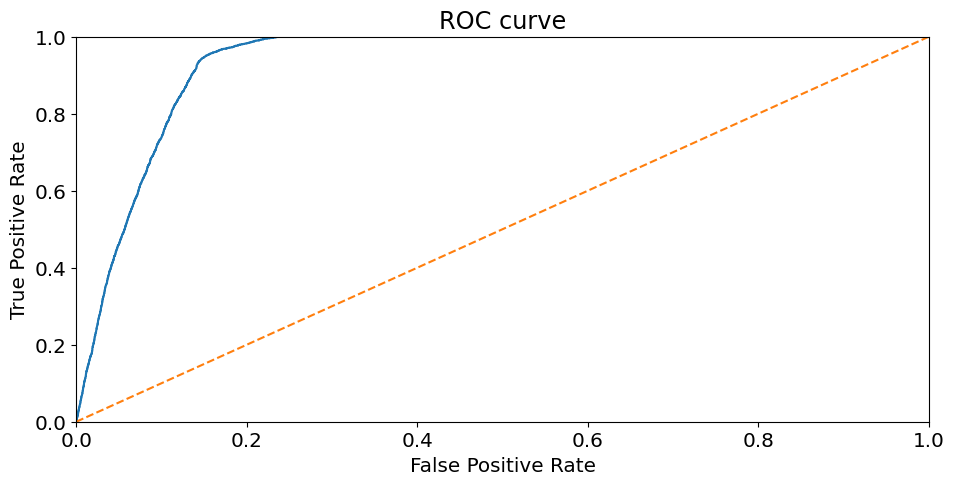

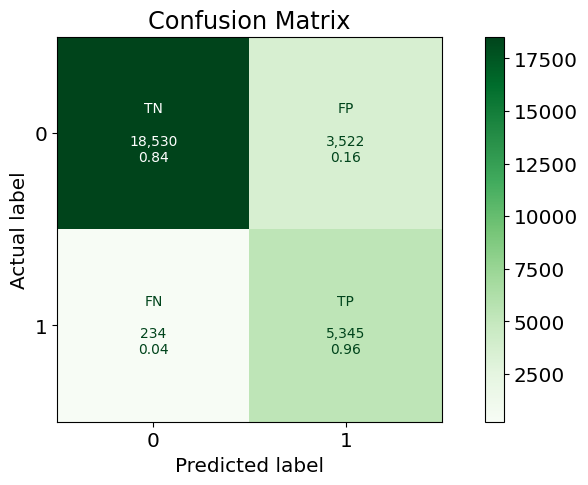

In [84]:
model_report(RandomForestClassifier, metric='precision', oversample=True, undersample=True)

We have 3,522 patients who were predicted not to show up - and eventually did show up.

In [90]:
print(f'False positive percent: {3522 / len(data):.2%}')

False positive percent: 3.19%


## Experiments

In [ ]:
# %%time
# tune_hyper(['f1'], params_grid, over_under=True)

In [ ]:
# %%time
# tune_hyper(['accuracy', 'roc_auc'], params_grid, oversample=True, undersample=True)

In [ ]:
# pprint(column_operations, width=1)

In [ ]:
# %%time

# tf = transform_columns({
#     'scale': [
#         'Age',
#         'Handcap',
#         'previous_no_show',
#         'weekday',
#     ],
#     'label': [
#         'Gender'
#     ],
#     'passthrough': [
#         'Scholarship',
#         'Hipertension',
#         'Diabetes',
#         'Alcoholism',
#         'SMS_received',
#         # 'weekend',
#         # *binary_columns
#     ]})

# results2 = tune_hyper(['precision'], params_grid, transform=tf, oversample=True, undersample=True)